# 0 Imports

In [33]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools

# 1 Text editing functions
The first few functions in this Python script pertain to editing or reading from the text files in LAMMPS. This could either be the logfile or the input script itself. 

I view these functions as the "fundamentals" in this code.

## 1.1 Extracting thermal conductivity from logfile
Log for thermal conductivity:

    print        "average conductivity: $k[W/mK] @ $T K, ${ndens} /A\^3"
    average conductivity: 0.316415655473469[W/mK] @ 70 K, 0.0257443666020476 /A\^3
    
so split the string such that we extract the number out only. Then the code checks to see if it contains that string (the thermal conductivity), and if it does, it filters it out. There's also a guard in case it doesn't find the thermal conductivity, which I guess is nice and can stop any potential errors.

In [34]:
def extract_TC(file_path):
    """Extracts the thermal conductivity (TC) value from the logfile,
    assuming that the LAMMPS script has already been run.
    Also takes their thermal conductivities
    
    Inputs:
    file_path - path to the logfile we want to read
    
    Outputs:
    thermal_conductivity - thermal conductivity extracted from the logfile (if it is there)
    k_x - thermal conductivity along the x direction extracted from logfile
    k_y - thermal conductivity along the y direction extracted from logfile
    k_z - thermal conductivity along the z direction extracted from logfile
    """
    
    # Open file in Python to read all lines
    with open(file_path, 'r') as file:
        content = file.read()

    # Looks for lines of the form {average conductivity: X[W/mk] @ 70 K, Y /A\^3}
    k_pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    # Search logfile for that line
    k_lines = k_pattern.findall(content)
    
    # If the line exists, extract thermal conductivity. Inform user if otherwise
    if len(k_lines)>0:
        thermal_conductivity = float(k_lines[0])
    else:
        return 'Thermal conductivity not found for this file'
    
    # Look for lines of the form {diretional thermal conductivites: k_x = kx, k_y = ky, k_z = kz}
    ki_pattern = re.compile(
        r'Directional thermal conductivities:\s*'
        r'k_x\s*=\s*(?P<kx>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_y\s*=\s*(?P<ky>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_z\s*=\s*(?P<kz>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)',
        re.IGNORECASE)
    
    # If the line exists, extract directional conductivity. Inform user if otherwise
    ki_lines = ki_pattern.findall(content)
    if ki_lines:
        kx_str, ky_str, kz_str = ki_lines[0]
        kx = float(kx_str)
        ky = float(ky_str)
        kz = float(kz_str)
    else:
        return 'Directional thermal conductivites not found for this file'
    
    return thermal_conductivity, kx, ky, kz

## 1.2 Updating the seed for the random velocities in LAMMPS
This must be the 'consideration of many seeds' that we were talking about. I'm assuming that taking many seeds for random generation would make the experiment more accurate. I like the idea.

In the LAMMPS input script (and actually the logfile too), we have the line

    velocity     all create $T 102486 mom yes rot yes dist gaussian

which initialises the velocities for the problem. The line of interest is the first line, which randomly generates the velocities from a normal distribution. The random generation seed is `102486` and we want to change this seed.

The one caveat is that this code assumes the velocity initialisation line is of the form

    velocity     all create $T $r mom yes rot yes dist gaussian

where `r` is a pre-defined seed, so `variable r equal {...}`. So I should be careful about that, but it's not much of a problem, all I would need to do is add a variable definition line.

Once again for my use case there is no reason to change this function, as my velocity initialisations should be the same.

In [35]:
def update_seed(file_path, new_seed):
    """Updates the seed for the velocity initialisation command in the LAMMPS input script.
    The velocity in LAMMPS is randomly initialised using a given seed.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_seed - new seed to be used in velocity initialisation
    
    Outputs:
    Updated file, if amendments have been made"""
    
    # Looks for lines of the form {variable r equal X}
    pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # If the pattern exists, update the line with the new seed in place
            if pattern.match(line):
                line = f"variable r equal {new_seed}\n"
            
            # Write the line to the file
            file.write(line)

## 1.3 Updating the masses of the atoms in LAMMPS input script
In the script/logfile, this will concern the line

    mass         1 {mass1}
    mass         2 {mass2}
    
so those two masses will be changed. Code below only does it for mass 1, but I imagine extending it for mass 2 would be super easy too. Functionally the code behaves exactly the same as the previous cell did, we target a specific line and replace it with something similar.

I amended Daniel's function slightly to account for the fact that both masses can be changed. This makes the function more general, but I don't know if I'd ever need to change both masses at the same time. Because the mass disorder should be relative between the masses.

In [36]:
def update_masses(file_path, new_mass1, new_mass2):
    """Updates the mass1 and mass2 variables in the LAMMPS input script.
    This assumes of course that the LAMMPS script concerns two fundamental atoms.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_mass1 - new mass 1 (g/mol)
    new_mass2 - new mass 2 (g/mol)
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Looks for lines of the form {mass    1 X} and {mass    2 Y}
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # --- Mass 1 ---
            # If the pattern exists, replace mass 1 with new_mass1
            if target_pattern_mass1.match(line):
                line = f"mass 1 {new_mass1}\n"
            # --- Mass 2 ---
            if target_pattern_mass2.match(line):
                line = f"mass 2 {new_mass2}\n"
                
            file.write(line)

## 1.4 Updating dimensonality of LAMMPS input script
One other thing which the LAMMPS input script has inside it is the dimensonality of the problem. This can be defined in a line like follows

    dimensonality X
    
where `X` would be either `2` or `3`. I anticipate that this project will be considering two-dimensional structures quite frequently. So, we will need to be able to change the dimensions in the LAMMPS input script very easily. The function below does exactly that, using the same pattern recognition techniques as above.

In [37]:
def update_dimensionality(file_path, new_dimension):
    """Updates the dimensionality written in the LAMMPS input script.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Look for lines of the form {dimension X}
    pattern = re.compile(r'^\s*dimension\s+(\d+)\b(?=\s*(?:#|$))')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        # Update any line which matches line pattern
        for line in lines:
            if pattern.match(line):
                line = f"dimension {new_dimension}\n"
            
            file.write(line)

# 1.5 Bash function
To run the LAMMPS input script, we need to pass in commands through the device's (Windows/MacOS) command line/prompt. This is relatively simple to do once, all that is needed is the following command

    lmp -in input.txt
    
The `lammps.sh` file, which can be run iteratively thanks to the defined function below, simply has two lines in it:

    #!/bin/bash
    lmp -in tc.txt > log_iteration_${i}.txt

so when we call this file in Python using `!bash` we automatically feed the command `lmp -in tc.txt` into the command prompt and this will be logged in `log.txt`.

To do this one would first need to install Git for their operating device: this adds the BASH emulation onto the device, which then must be further defined as an environment system variable.

In [38]:
def run_bash():
    """ I want to describe this better """
    !bash {'lammps.sh'}
    return

# 2 Finding the thermal conductivity of argon
Having created a few functions which allow us to conveniently edit the LAMMPS input file, whether it be for increased accuracy or further testing, we can now move onto applying these functions to a use case.

This project focuses on minimising the thermal conductivity of solids. For this, we likely need to consider complicated structures. These structures are quite difficult to produce in LAMMPS - we can instead construct them in Python. 

Ideally, the structures we want to create are closely packed structures, i.e. HCP and FCC (both have a packing fraction of 74%). In these types of molecular dynamics simulations, stability of our system is incredibly important. A closely packed structure is very stable, due to the high amount of nearest neighbours. Thus, these structures are less likely to fall apart during MD simulations.

So, we will need to create a function (or functions) that construct(s) a FCC/HCP structure. In this section, we will create such a function that produces argon, which is a FCC lattice.

Why argon? Simply because its thermal conductivity has been extensively studied and measured. It's been studied so much that in the LAMMPS documentation, there is an example where the thermal conductivity of argon is calculated, simply from an input file where the structure itself is also created.

We will create a function that produces a FCC lattice, then adjust the masses and spacing parameters such that we are able to produce a lattice of solid argon. Then we will compute the thermal conductivity of this created lattice of argon, and compare it to the thermal conductivity of the argon created within LAMMPS' example input file. The two should be similar. By doing this, we can verify that our FCC structure generation is correct, thus we can apply it to more interesting scenarios.

## 2.1 FCC structure generation
Originally I inspired my function from the following website: https://www.physicstomato.com/crystal-lattice/. This used a "parity" approach, and it importantly led me to understand how I can construct "arbitrary" structures like the two they go through in the examples.

However, for the fcc creation I decided to use something simpler. An illustration of my thought process is below

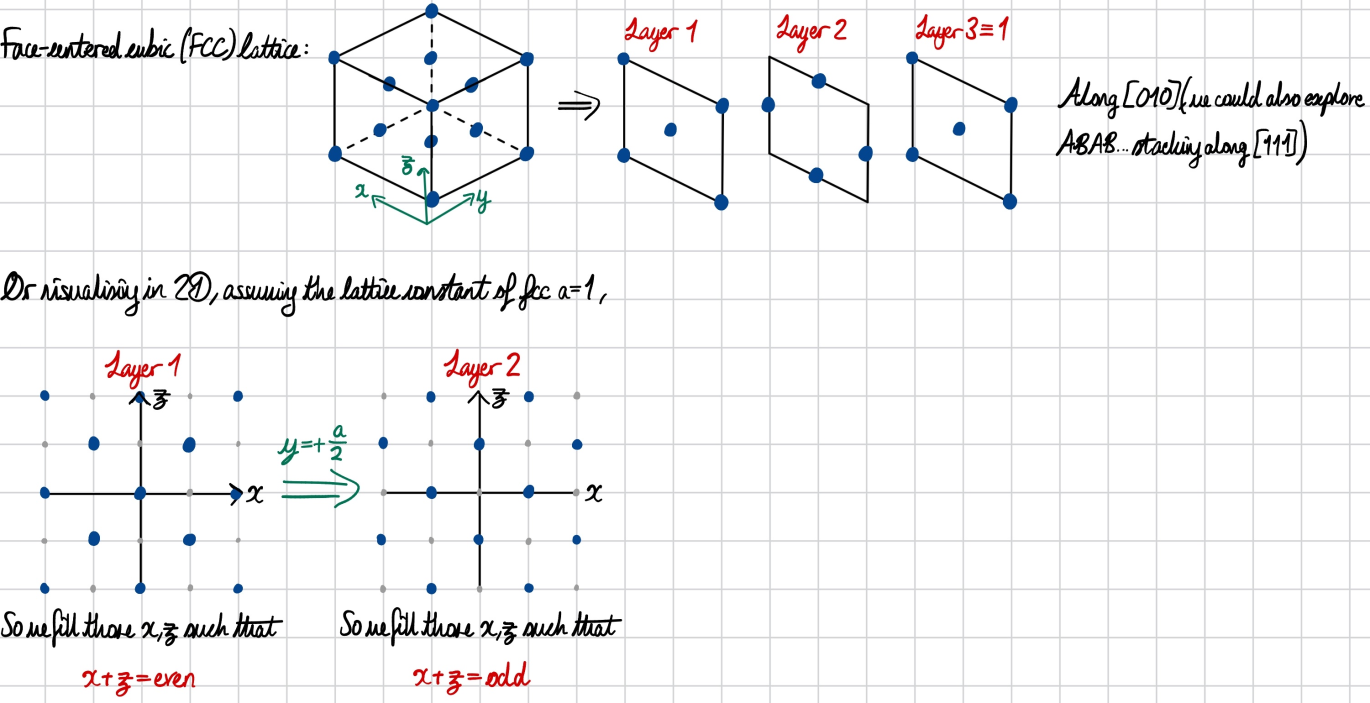

For now, I create this function such that there is only one type of atom involved, as we want to replicate solid argon - that's monoatomic.

In [39]:
def generate_FCC(Ncells, Nlayers, spacings):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes one type of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers"""
    # Create storage arrays
    positions = []
    atom_types = []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)

    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        # Check the first layer:
        if y%2 == 0:
            # Check if x+z is even
            if (x+z)%2 == 0:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2)*y_spacing
                # Append positions and types
                positions.append([x,y,z])
                atom_types.append(int(1))
                
        # Check the second layer
        elif y%2 == 1:
            # Check if x+z is odd
            if (x+z)%2 == 1:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2 + 0.5)*y_spacing
                # Append positions and types
                positions.append([x,y,z])
                atom_types.append(int(1))
                                    
    # Convert lists to arrays for plotting & return
    positions = np.array(positions)
    atom_types = np.array(atom_types)
    
    return positions, atom_types

### Rudimentary verification of function
I would prefer to double check this function visually, by perhaps plotting it in Python. I could also have used VMD. But actually the plots were quite difficult to understand - this does not mean they have been done incorrectly. Instead I'll check to see if the number of atoms we have, as per the array `atom_types`, matches the amount of atoms we expect for a FCC basis with a given cell span.

In [40]:
# Obtain positions and atom types of FCC structure
Ncells = np.array([2,2])
Nlayers = 2
spacings = np.array([5.376,5.376,5.376])
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
len(atom_types)

32

As FCC has 4 atoms/conventional cell, $4 \times 2 \times 2 \times 2 = 32$ indeed

In [41]:
# Obtain positions and atom types of FCC structure
Ncells = np.array([2,2])
Nlayers = 4
spacings = np.array([5.376,5.376,5.376])
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
len(atom_types)

64

$4 \times 2 \times 2 \times 4 = 64$ aswell

In [42]:
# Obtain positions and atom types of FCC structure
Ncells = np.array([5,3])
Nlayers = 7
spacings = np.array([5.376,5.376,5.376])
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
len(atom_types)

420

$4 \times 5 \times 3 \times 7 = 420$, so the amount of atoms we have matches the amount of cells and layers we defined our system to have. What follows next is of course a far more robust check.

## 3.1 Creating a LAMMPS-compatible datafile

In [43]:
def layered_datafile_creation(Ncells, Nlayers, spacings):
    """Creates a datafile of an arbitrary crystallographic material which is LAMMPS compatible.
    Uses the generate_FCC function to generate FCC lattice.
    See the markdown above where this function is defined for details on the datafile structure.
    Alternativiely, view the eim example in LAMMPS.
    
    Inputs:
    
    Output:
    datafile.txt - datafile in LAMMPS format defining the structure"""

    # Find positions, types, IDs and group into data
    positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((IDs, atom_types, positions))

    # Will take the form [ID] [Type] [X1] [Y1] [Z1] column-repeated many times
    np.savetxt('datafile.txt', data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

{min(positions[:,0])} {max(positions[:,0]) + 0.5*spacings[0]} xlo xhi
{min(positions[:,1])} {max(positions[:,1]) + 0.5*spacings[1]} ylo yhi
{min(positions[:,2])} {max(positions[:,2]) + 0.5*spacings[2]} zlo zhi

Atoms
''', comments = '')
    
    return

## Computing thermal conductivity of argon according to our datafile

In [10]:
# Assume 4x4x4 lattice, with lattice constant=5.376 angstroms
Ncells = np.array([4,4])
Nlayers = 4
spacings = np.array([5.376,5.376,5.376])

# Create datafile containing positions & types
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
layered_datafile_creation(Ncells, Nlayers, spacings)

# Run the thermal conductivity computation
update_seed("tc.txt", 102486)
run_bash()
tc = extract_TC("log.lammps")
print(tc)

0.288967492742944


Whereas the LAMMPS input file for argon gives a thermal conductivity of about 0.31 W/mK - so the two are fairly close. There is a difference of about 10%, why might this be happening? Nevertheless it's far better than before and decently accurate.

## Monoatomic 20x2x2, same mass density as above

$$39.948 + 100 = 139.948 / 2 = 69.974$$
(I did the above in my head)


In [44]:
# Investigate 2x2xn sizes, where n is the amount of layers
Ncells = np.array([2,2])
Nlayers = np.arange(2, 21).astype(int)
spacings = np.array([5.376,5.376,5.376])

# Setup array storage
k_averages, k_errors = [], []
kx_averages, kx_errors = [], []
ky_averages, ky_errors = [], []
kz_averages, kz_errors = [], []

# Loop over increasing layers
for layers in tqdm(Nlayers):
    # Create datafile for LAMMPS to use
    layered_datafile_creation(Ncells, layers, spacings)
    # Update seeds
    seeds = np.random.randint(1,10000,5)
    # Thermal conductivites per layer
    k_run, kx_run, ky_run, kz_run = [], [], [], []
    # Loop over seeds
    for seed in seeds:
        update_seed("tc.txt", seed)
        run_bash()
        # Extract TC and directional TC
        k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
        # Store all seed TC's
        k_run.append(k_seed)
        kx_run.append(kx_seed)
        ky_run.append(ky_seed)
        kz_run.append(kz_seed)
    # Find all TC averages per layer
    k_averages.append(np.mean(k_run))
    kx_averages.append(np.mean(kx_run))
    ky_averages.append(np.mean(ky_run))
    kz_averages.append(np.mean(kz_run))
    # Also find their errors
    k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
    kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
    ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
    kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:21:09<00:00, 256.31s/it]


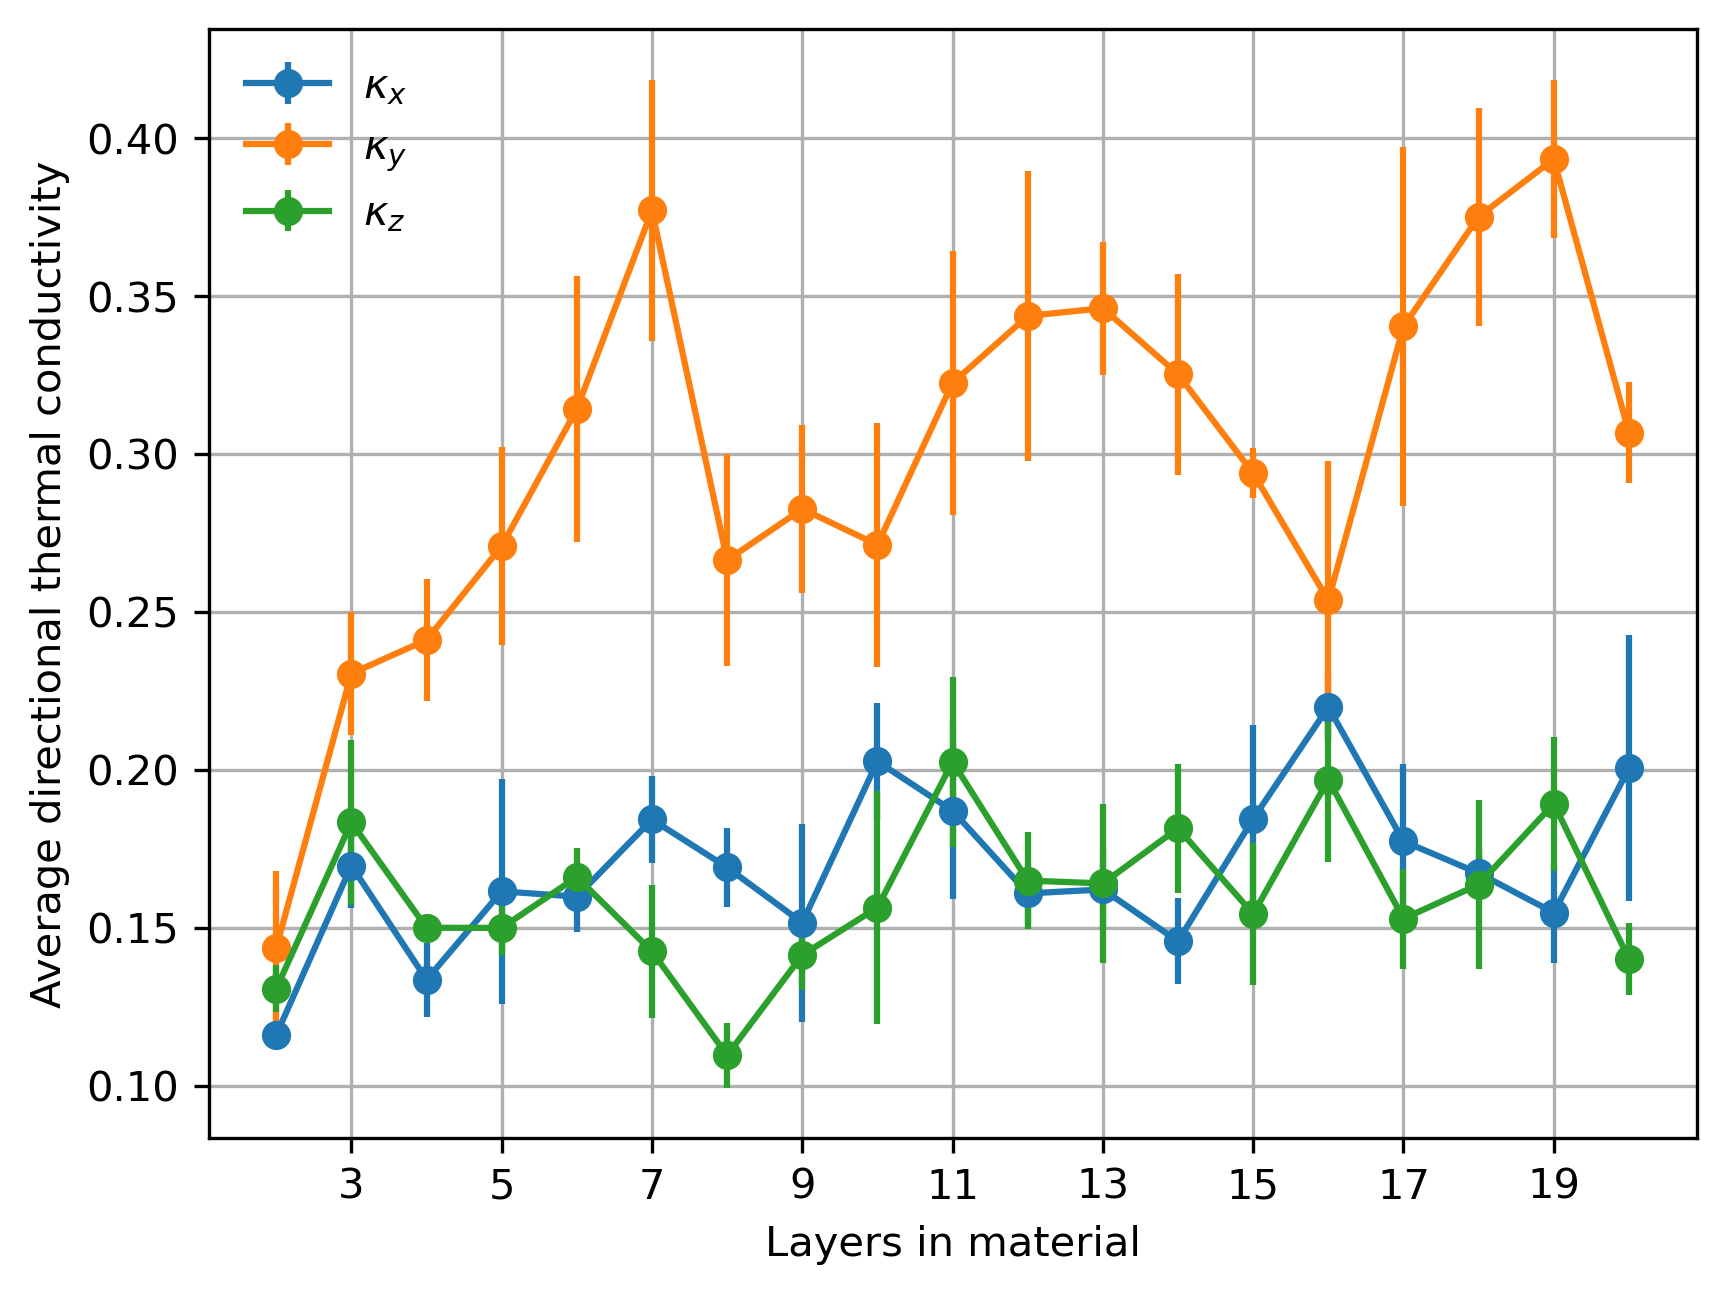

In [45]:
plt.errorbar(Nlayers, kx_averages, yerr=kx_errors, fmt='o-', label="$\kappa_x$")
plt.errorbar(Nlayers, ky_averages, yerr=ky_errors, fmt='o-', label="$\kappa_y$")
plt.errorbar(Nlayers, kz_averages, yerr=kz_errors, fmt='o-', label="$\kappa_z$")
plt.xticks(Nlayers[1::2])
plt.grid()
plt.xlabel("Layers in material")
plt.ylabel("Average directional thermal conductivity")
plt.legend()

On average all three components of the thermal conductivity are larger than for the diatomic case. Once again a large $\kappa_y$ is observed, and this is not surprising given that we have added more atoms along the $y-$direction. As the number of atoms in the $x-$ and $z-$directions were kept the same, it is good to see that their thermal conductivities remained roughly the same both as eachother and throughout increasing layers. Most of them are within eachother's margin of error.

In [46]:
print("For two layers, \n")
print(f"Thermal conductivity k={k_averages[0]} W/m^3 with error {k_errors[0]} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_averages[0]} W/m^3 with error {kx_errors[0]} W/m^3 \n ky = {ky_averages[0]} W/m^3 with error {ky_errors[0]} W/m^3 \n kz = {kz_averages[0]} W/m^3 with error {kz_errors[0]} W/m^3")

For two layers, 

Thermal conductivity k=0.13007702943254942 W/m^3 with error 0.010131768896679794 W/m^3
Directional thermal conductivities: 
 kx = 0.11601001750914079 W/m^3 with error 0.003469273499394561 W/m^3 
 ky = 0.14357664084126606 W/m^3 with error 0.02433506989566646 W/m^3 
 kz = 0.13064442994724162 W/m^3 with error 0.0073721198559030775 W/m^3


Conversely to the diatomic case we can see here that all three dimensional thermal conductivities are about the same for the 2x2x2 cubic arrangement. We investigate this in a bit more detail below

In [47]:
print("For twenty layers, \n")
print(f"Thermal conductivity k={k_averages[-1]} W/m^3 with error {k_errors[-1]} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_averages[-1]} W/m^3 with error {kx_errors[-1]} W/m^3 \n ky = {ky_averages[-1]} W/m^3 with error {ky_errors[-1]} W/m^3 \n kz = {kz_averages[-1]} W/m^3 with error {kz_errors[-1]} W/m^3")

For twenty layers, 

Thermal conductivity k=0.21577793135302584 W/m^3 with error 0.01633634139381827 W/m^3
Directional thermal conductivities: 
 kx = 0.20051896615567638 W/m^3 with error 0.04215704842769164 W/m^3 
 ky = 0.3067578067540974 W/m^3 with error 0.015953739967949868 W/m^3 
 kz = 0.1400570211493036 W/m^3 with error 0.011411268280890965 W/m^3


Adding more layers in the $y-$direction has increased the thermal conductivity along $y$, whereas those along $x$ and $z$ have remained about the same. This is not so surprising given the large amount of atoms in the $y-$direction.

## Cubic arrangement
$$20 \times 2 \times 2 \times 4 = 320$$

The problem is $320$ isn't a cubed number, but it lies inbetween $6^3 = 216$ and $7^3 = 343$, so I will investigate 6x6x6 and 7x7x7 arrangements.

In [49]:
spacings = np.array([5.376,5.376,5.376])

# Setup array storage
k_averages, k_errors = [], []
kx_averages, kx_errors = [], []
ky_averages, ky_errors = [], []
kz_averages, kz_errors = [], []

# Loop over increasing layers
for n in tqdm(np.array([2,6,7])):
    # Create datafile for LAMMPS to use
    Ncells = np.array([n,n])
    layered_datafile_creation(Ncells, n, spacings)
    # Update seeds
    seeds = np.random.randint(1,10000,5)
    # Thermal conductivites per layer
    k_run, kx_run, ky_run, kz_run = [], [], [], []
    # Loop over seeds
    for seed in seeds:
        update_seed("tc.txt", seed)
        run_bash()
        # Extract TC and directional TC
        k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
        # Store all seed TC's
        k_run.append(k_seed)
        kx_run.append(kx_seed)
        ky_run.append(ky_seed)
        kz_run.append(kz_seed)
    # Find all TC averages per layer
    k_averages.append(np.mean(k_run))
    kx_averages.append(np.mean(kx_run))
    ky_averages.append(np.mean(ky_run))
    kz_averages.append(np.mean(kz_run))
    # Also find their errors
    k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
    kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
    ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
    kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [59:17<00:00, 1185.74s/it]


In [50]:
print("For a 2x2x2 structure, \n")
print(f"Thermal conductivity k={k_averages[0]} W/m^3 with error {k_errors[0]} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_averages[0]} W/m^3 with error {kx_errors[0]} W/m^3 \n ky = {ky_averages[0]} W/m^3 with error {ky_errors[0]} W/m^3 \n kz = {kz_averages[0]} W/m^3 with error {kz_errors[0]} W/m^3")

For a 2x2x2 structure, 

Thermal conductivity k=0.15315972422878082 W/m^3 with error 0.010236952530690395 W/m^3
Directional thermal conductivities: 
 kx = 0.1664995310864224 W/m^3 with error 0.025308245672523447 W/m^3 
 ky = 0.1372838366863479 W/m^3 with error 0.015257116195389652 W/m^3 
 kz = 0.1556958049135718 W/m^3 with error 0.015413020186469385 W/m^3


Well there was actually no reason to do this, considering we had already done it before in the increasing layers approach. But in comparison to the 2x2x2 diatomic material we see that the thermal conductivity here is larger in all three directions, with a massive increase in the y direction. 

In [51]:
print("For a 6x6x6 structure, \n")
print(f"Thermal conductivity k={k_averages[1]} W/m^3 with error {k_errors[1]} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_averages[1]} W/m^3 with error {kx_errors[1]} W/m^3 \n ky = {ky_averages[1]} W/m^3 with error {ky_errors[1]} W/m^3 \n kz = {kz_averages[1]} W/m^3 with error {kz_errors[1]} W/m^3")

For a 6x6x6 structure, 

Thermal conductivity k=0.22372356079614558 W/m^3 with error 0.014561706912572053 W/m^3
Directional thermal conductivities: 
 kx = 0.22848079833757123 W/m^3 with error 0.03640243267802261 W/m^3 
 ky = 0.22199034206970997 W/m^3 with error 0.018336488353204942 W/m^3 
 kz = 0.2206995419811552 W/m^3 with error 0.01750126775826101 W/m^3


All thermal conductivites are very similar to eachother, and this is expected because of the symmetry of the simulation. Note the thermal conductivity has increased once again.

In [52]:
print("For a 7x7x7 structure, \n")
print(f"Thermal conductivity k={k_averages[2]} W/m^3 with error {k_errors[2]} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_averages[2]} W/m^3 with error {kx_errors[2]} W/m^3 \n ky = {ky_averages[2]} W/m^3 with error {ky_errors[2]} W/m^3 \n kz = {kz_averages[2]} W/m^3 with error {kz_errors[2]} W/m^3")

For a 7x7x7 structure, 

Thermal conductivity k=0.243218711155868 W/m^3 with error 0.01633931557815951 W/m^3
Directional thermal conductivities: 
 kx = 0.26194247705140195 W/m^3 with error 0.020390309848684313 W/m^3 
 ky = 0.2441692225586924 W/m^3 with error 0.023084136458155817 W/m^3 
 kz = 0.2235444338575098 W/m^3 with error 0.023406853826489608 W/m^3
